# Self-supervised vesselness

We will use a notebook to debug and check parameters for a single image. This is similar to the `Deep Image Prior` paper.

In [28]:
import argparse
import collections
import torch
import numpy as np
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from parse_config import ConfigParser
from trainer import VesselTrainer
from utils import dir2flow_2d, overlay, overlay_quiver
from sklearn import metrics as M
from copy import deepcopy
import pickle as pkl

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [29]:
class Args:
    def __init__(self):
        self.config = 'configs/drivemaskv2_scale8.json'
#         self.config = 'configs/toydrive.json'
        self.resume = None
        self.run_id = ''
        self.device = None

args = Args()
IDX = 0

Given this config, now we would like to initialize all variables like data loader, model architecture, optimizer, etc.

# Modify the custom loss function here

In [30]:
from model.loss import *


# Output vesselness
def v2vesselness(image, ves, nsample=10, vtype='light', mask=None, percentile=100, is_crosscorr=False):
    response = 0.0
    i_range = []
    
    # Perpendicular direction
    v1 = ves*0
    v1[:, 0] = -v1[:, 1]
    v1[:, 1] = v1[:, 0]
    
    for sv in np.linspace(-2, 2, nsample):
        # Sample image from slightly forward
        im = resample_from_flow_2d(image, sv*v1)
        
        # Take perpendicular profile here
        for s in np.linspace(-2, 2, nsample):
            filt = 2*int(abs(s) < 1) - 1
            i_val = resample_from_flow_2d(im, s*ves)
            if is_crosscorr:
                i_range.append(i_val.detach()[:, None])
            # Compute the convolution I * f
            response = response + (i_val * filt)/(nsample**2)

    # Normalize
    if is_crosscorr:
        i_range = torch.cat(i_range, 1)   # [B, 20, 1, H, W]
        i_std = i_range.std(1) + 1e-10    # [B, 1, H, W]
        response = response / i_std

    # Correct the response accordingly
    if vtype == 'light':
        pass
    elif vtype == 'dark':
        response = -response
    elif vtype == 'both':
        response = torch.abs(response)
    else:
        raise NotImplementedError('{} type not supported in vesseltype'.format(vtype))

    # We got the response, now subtract from mean and multiply with optional mask
    response = response - response.min()
    if mask is not None:
        response = response * mask
        # Change percentile
        if percentile < 100:
            for i in range(response.shape[0]):
                r = response[i] + 0
                r = r.data.cpu().numpy()
                per_val = np.percentile(r, percentile)
                r[r > per_val] = per_val
                response[i] = torch.FloatTensor(r)

    return response


## Create a custom loss
def custom_loss(output, data, config):
    '''
    Master loss function of vessel self supervised learning
    '''
    args = config['loss_args']
    # Get all parameters
    num_dir = args['num_directions'] # Determine the directions
    unc = args['uncertainty'] # whether to use kappa uncertainty
    eps = args['eps']
    L_loss = LOSS_FNs[args['loss_intensity']]
    # Weights for different parts of total loss
    l_intensity = args.get('lambda_intensity')
    l_consistency = args.get('lambda_consistency')
    l_cosine = args.get('lambda_cosine')
    l_decoder = args.get('lambda_decoder')
    l_length = args.get('lambda_length')

    # Add extra parameters -> length and matching of template profile
    l_template = args.get('lambda_template')
    num_samples_template = args.get('num_samples_template', 10)
    l_perlength = args.get('lambda_perlength')
    detach = args.get('detach', True)
    # This parameter is for type of vessel
    vessel_type = config.get('vessel_type', 'light') # should be light, dark or both

    # parameter for followup vesselness
    l_followupv = args.get('lambda_followupv')

    # check if we want to minimize cross correlation
    #is_crosscorr = args.get('is_crosscorr', False)
    is_crosscorr = args.get('is_crosscorr', False)

    # Get outputs and inputs
    recon = output['recon']
    vessel = output['vessel']
    image = data['image']

    # Take mask for all losses
    mask = data.get('mask', 1)
    if not args.get('use_mask', False):
        mask = 1

    # Now use the losses given in the config
    if num_dir == 2 and not unc:
        assert config['arch']['args']['out_channels'] == 4, 'Model with 2 directions and no uncertainty'
        # parameters are v1, v2
        loss = 0.0
        v1 = vessel[:, :2]
        v2 = vessel[:, 2:]
        # Intensity consistency loss
        if l_intensity:
            for scale in [0.2, 0.4, 0.6, 0.8, 1]:
                # Check for both directions for same intensity -> this will help in centerline prediction
                i_parent = resample_from_flow_2d(image, scale*v1)
                i_child = resample_from_flow_2d(image, scale*v2)
                i_child2 = resample_from_flow_2d(image, -scale*v2)
                L_childloss = torch.max(L_loss(image, i_child, mask=mask), L_loss(image, i_child2, mask=mask))
                # add parent and child loss
                # Add that loss
                loss = loss + l_intensity * (L_loss(image, i_parent, mask=mask) + L_childloss)/5.0

        # Flow consistency loss
        if l_consistency:
            # If v1, v2 are supposed to be opposite directions
            loss = loss + l_consistency * L2(flow_consistency_2d(v1, -v1), mask=mask)

        # Check for cosine similarity
        if l_cosine:
            loss = loss + l_cosine * torch.abs(mask * F.cosine_similarity(v1, v2)[:, None]).mean()

        # Check for decoder
        if l_decoder:
            loss = loss + l_decoder * L2(image, recon, mask=1)

        # Check for length of vector
        if l_length:
            v1norm = torch.sqrt((v1**2).sum(1) + eps)[:, None]
            loss = loss + l_length * L1(1./v1norm, mask=mask)

        # Check for length of vector for perpendicular line
        if l_perlength:
            v2norm = torch.sqrt((v2**2).sum(1) + eps)[:, None]
            loss = loss + l_perlength * L1(v2norm, mask=mask)

        # Check profile by taking convolution with the template [-1 -1 1 1 1 1 -1 -1]
        if l_template:
            vessel_conv = v2vesselness(image, v2, vtype=vessel_type, mask=mask, is_crosscorr=is_crosscorr)
            loss = loss + l_template*(1 - (mask*vessel_conv).mean())

        # Check for vesselness in followup
        if l_followupv and l_template:
            # we have already calculated the vesselness
            followup_vessel = resample_from_flow_2d(vessel_conv, v1)
            loss = loss + l_followupv * (1 - (mask*followup_vessel).mean())

    else:
        raise NotImplementedError

    # Return loss
    return loss


In [31]:
config = ConfigParser.from_args(args, '', parse=False)
# Augment some things here for dataloader
config.config['data_loader']['type'] = 'DRIVEContrastDataLoader'

config.config['arch']['args']['vessel_scale_factor'] = 16
config.config['data_loader']['args']['augment'] = False
config.config['data_loader']['args']['validation_split'] = 0
config.config['data_loader']['args']['idx'] = IDX   # Use just one index

# config.config['optimizer']['args']['lr'] = 1e-2
# config.config['arch']['type'] = 'DeepLabV3'

data_loader = config.init_obj('data_loader', module_data)
config.config['data_loader']['args']['toy'] = True
gt_loader = config.init_obj('data_loader', module_data)

model = config.init_obj('arch', module_arch).cuda()
# criterion = getattr(module_loss, config['loss'])
criterion = custom_loss
metrics = [getattr(module_metric, met) for met in config['metrics']]

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)


backup_config = deepcopy(config)

Preserving indices:  [0]
Preserving indices:  [0]


In [32]:
print(len(data_loader.dataset))
print(len(data_loader))
print(data_loader.dataset.images)

1
1
['/pghbio/dbmi/batmanlab/rohit33/DRIVE/training/images/21_training.tif']


### Given these parameters, try to run it for a single image or batch

In [33]:
print(dict(config['loss_args']))
# Change loss args here
config.config['loss_args'] = {
        "num_directions": 2,
        "eps": 1e-1,
        "uncertainty": False,
        "loss_intensity": "L2",
        "lambda_intensity": 0,
        "lambda_consistency": 0,
        "lambda_cosine": 1,
        "lambda_decoder": 1,
        "lambda_length": 0,
        "lambda_template": 1,
        "is_crosscorr": True,
        "use_mask": True,
        "num_samples_template": 20,
        "lambda_followupv": 0,
        "lambda_perlength": 0
}

{'num_directions': 2, 'eps': 0.1, 'uncertainty': False, 'loss_intensity': 'L2', 'lambda_intensity': 0.1, 'lambda_consistency': 0.2, 'lambda_cosine': 1, 'lambda_decoder': 1, 'lambda_length': 1, 'lambda_template': 5, 'is_crosscorr': True, 'use_mask': True, 'detach': True, 'num_samples_template': 20, 'lambda_followupv': 0, 'lambda_perlength': 0.1}


In [34]:
%pylab
%matplotlib inline

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [35]:
'''
Run it for a single image
'''
def cuda(data):
    for k, v in data.items():
        data[k] = v.cuda()
    return data


def _train_epoch(epoch, gt=None, logepoch=100):
    """
    Training logic for an epoch

    :param epoch: Integer, current training epoch.
    :return: A log that contains average loss and metric in this epoch.
    """
    # Get parameters for quiver
    params = config['trainer']
    normflow = params.get('normalize_flow', True)
    normflowrev = params.get('normalize_flow_rev', True)
    quiverscale = params.get('quiver_scale', 2)
    
    # Get vessel type here
    vessel_type = config.get('vessel_type', 'light')
    
    auc = 0
    model.train()
    for batch_idx, data in enumerate(data_loader):
        # Move tensors to device
        data = cuda(data)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data, config)
        loss.backward()
        optimizer.step()
        
        mask = data.get('mask')
        if mask is not None:
            mask = mask.cpu()         
        
        if gt is None:
            print("Epoch: {}, Loss: {}".format(epoch, loss.data.cpu().numpy()))
        else:
            ves = v2vesselness(data['image'].cpu(), output['vessel'][:, 2:4].cpu(), \
               vtype=vessel_type, mask=mask, is_crosscorr=False)
            # Get auc value
            V = ves[0, 0].data.cpu().numpy()
            g = gt[0, 0].data.cpu().numpy().astype(int)
            V = (V - V.min())/(V.max() - V.min())
            try:
                fpr, tpr, thres = M.roc_curve(g.reshape(-1), V.reshape(-1), pos_label=1)
                auc = M.auc(fpr, tpr)
            except:
                auc = 0
            print("Epoch: {}, Loss: {:2f}, AUC: {:2f}".format(epoch, loss.data.cpu().numpy(), auc))            

        
    if (epoch+1) % logepoch == 0:
        # Get images to inspect
        try:
            q1 = overlay_quiver(data['image'].cpu(), output['vessel'][:, 0:2].cpu(), quiverscale, normflowrev)
            q2 = overlay_quiver(data['image'].cpu(), output['vessel'][:, 2:4].cpu(), quiverscale, normflowrev)
            ves = v2vesselness(data['image'].cpu(), output['vessel'][:, 2:4].cpu(), \
                               vtype=vessel_type, mask=mask, is_crosscorr=False)
        except:
            pass
    else:
        q1 = q2 = None

    return q1, q2, ves, auc

In [36]:
auc_list = []

for data in gt_loader:
    gt = data['image']
    gt = (gt > 0.5).float()
    break

Epoch: 0, Loss: -66063912.000000, AUC: 0.740118
Epoch: 1, Loss: -66233420.000000, AUC: 0.737655
Epoch: 2, Loss: -65952560.000000, AUC: 0.734962
Epoch: 3, Loss: -65897248.000000, AUC: 0.732484
Epoch: 4, Loss: -66102652.000000, AUC: 0.731031
Epoch: 5, Loss: -66127620.000000, AUC: 0.730592
Epoch: 6, Loss: -65255296.000000, AUC: 0.730089
Epoch: 7, Loss: -62644408.000000, AUC: 0.729613
Epoch: 8, Loss: -59228732.000000, AUC: 0.729522
Epoch: 9, Loss: -55901572.000000, AUC: 0.730125
Epoch: 10, Loss: -55189400.000000, AUC: 0.730361
Epoch: 11, Loss: -53100248.000000, AUC: 0.730537
Epoch: 12, Loss: -50835552.000000, AUC: 0.728647
Epoch: 13, Loss: -51874504.000000, AUC: 0.726434
Epoch: 14, Loss: -53159936.000000, AUC: 0.724065
Epoch: 15, Loss: -54455184.000000, AUC: 0.721499
Epoch: 16, Loss: -54692732.000000, AUC: 0.718831
Epoch: 17, Loss: -53824360.000000, AUC: 0.716608
Epoch: 18, Loss: -51359072.000000, AUC: 0.715076
Epoch: 19, Loss: -48096936.000000, AUC: 0.714482
Epoch: 20, Loss: -47785252.000

Epoch: 167, Loss: -85627160.000000, AUC: 0.681359
Epoch: 168, Loss: -84609080.000000, AUC: 0.682402
Epoch: 169, Loss: -84361928.000000, AUC: 0.683183
Epoch: 170, Loss: -84553816.000000, AUC: 0.683690
Epoch: 171, Loss: -84863408.000000, AUC: 0.684320
Epoch: 172, Loss: -84674976.000000, AUC: 0.684923
Epoch: 173, Loss: -84341872.000000, AUC: 0.685692
Epoch: 174, Loss: -84388368.000000, AUC: 0.686043
Epoch: 175, Loss: -84663248.000000, AUC: 0.686233
Epoch: 176, Loss: -85130088.000000, AUC: 0.686570
Epoch: 177, Loss: -84861760.000000, AUC: 0.686809
Epoch: 178, Loss: -84434888.000000, AUC: 0.687584
Epoch: 179, Loss: -84682992.000000, AUC: 0.692262
Epoch: 180, Loss: -84734208.000000, AUC: 0.693783
Epoch: 181, Loss: -84430784.000000, AUC: 0.694711
Epoch: 182, Loss: -81716784.000000, AUC: 0.697706
Epoch: 183, Loss: -80108224.000000, AUC: 0.698020
Epoch: 184, Loss: -81193392.000000, AUC: 0.692855
Epoch: 185, Loss: -85822824.000000, AUC: 0.683343
Epoch: 186, Loss: -89501736.000000, AUC: 0.677976


Epoch: 330, Loss: -128072624.000000, AUC: 0.711784
Epoch: 331, Loss: -129259360.000000, AUC: 0.714653
Epoch: 332, Loss: -123307936.000000, AUC: 0.715160
Epoch: 333, Loss: -118674784.000000, AUC: 0.715358
Epoch: 334, Loss: -117600528.000000, AUC: 0.712815
Epoch: 335, Loss: -116754096.000000, AUC: 0.710059
Epoch: 336, Loss: -115339360.000000, AUC: 0.706891
Epoch: 337, Loss: -115530840.000000, AUC: 0.705608
Epoch: 338, Loss: -116514048.000000, AUC: 0.704313
Epoch: 339, Loss: -119396016.000000, AUC: 0.703406
Epoch: 340, Loss: -122168416.000000, AUC: 0.702866
Epoch: 341, Loss: -124127096.000000, AUC: 0.702155
Epoch: 342, Loss: -124648544.000000, AUC: 0.701263
Epoch: 343, Loss: -124119200.000000, AUC: 0.701424
Epoch: 344, Loss: -123733152.000000, AUC: 0.702748
Epoch: 345, Loss: -123746944.000000, AUC: 0.703861
Epoch: 346, Loss: -123959480.000000, AUC: 0.704692
Epoch: 347, Loss: -124096448.000000, AUC: 0.705438
Epoch: 348, Loss: -123937544.000000, AUC: 0.705806
Epoch: 349, Loss: -123973432.00

Epoch: 491, Loss: -153724960.000000, AUC: 0.683500
Epoch: 492, Loss: -154223104.000000, AUC: 0.685950
Epoch: 493, Loss: -154665456.000000, AUC: 0.687666
Epoch: 494, Loss: -143437504.000000, AUC: 0.684899
Epoch: 495, Loss: -132303712.000000, AUC: 0.686838
Epoch: 496, Loss: -122478920.000000, AUC: 0.687867
Epoch: 497, Loss: -120584848.000000, AUC: 0.665242
Epoch: 498, Loss: -122528144.000000, AUC: 0.647015
Epoch: 499, Loss: -127504696.000000, AUC: 0.636269


(-0.5, 511.5, 511.5, -0.5)

<Figure size 1152x1152 with 0 Axes>

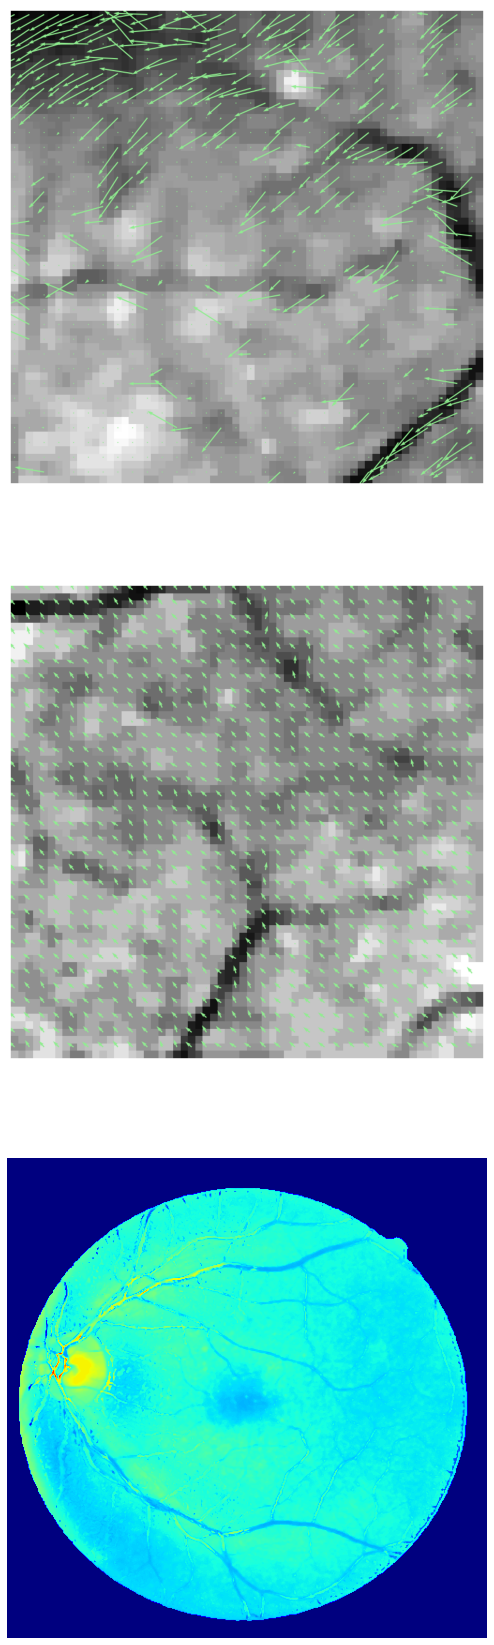

In [39]:
for _ in range(500):
    q1, q2, ves, auc = _train_epoch(_, gt, 50)
    auc_list.append(auc)

plt.clf()
plt.figure(figsize=(10, 30))
plt.subplot(311)
plt.imshow(q1[0].data.cpu().numpy().transpose(1, 2, 0)/255.)
plt.axis('off')
plt.subplot(312)
plt.imshow(q2[0].data.cpu().numpy().transpose(1, 2, 0)/255.)   
plt.axis('off')
plt.subplot(313)
plt.imshow(ves[0, 0].data.cpu().numpy(), 'jet')
plt.axis('off')

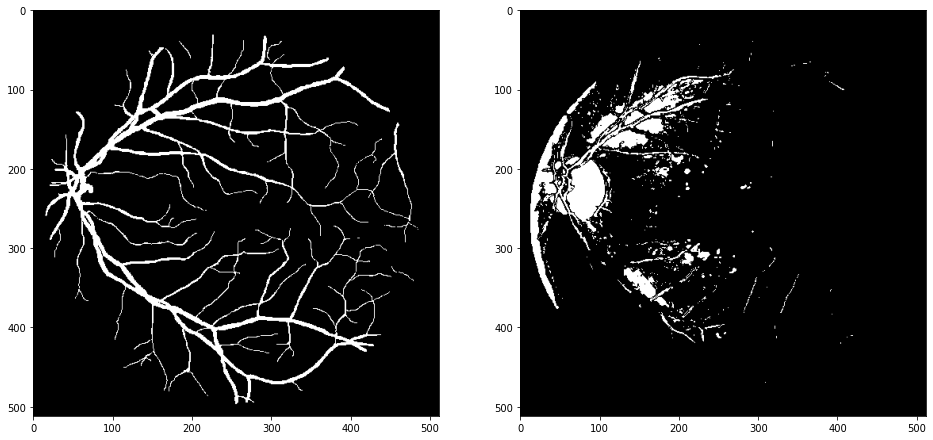

In [40]:
'''
Visualize vesselness
'''
thres_ours = 0.53535219073295594

V = ves[0, 0].data.cpu().numpy()
V = (V - V.min())/(V.max() - V.min())
mask = data['mask'][0, 0].data.cpu().numpy()
g = gt[0, 0].data.cpu().numpy() 

plt.figure(figsize=(16, 16))
plt.subplot(121)
plt.imshow(g, 'gray')
plt.subplot(122)
plt.imshow(V>0.425, 'gray')

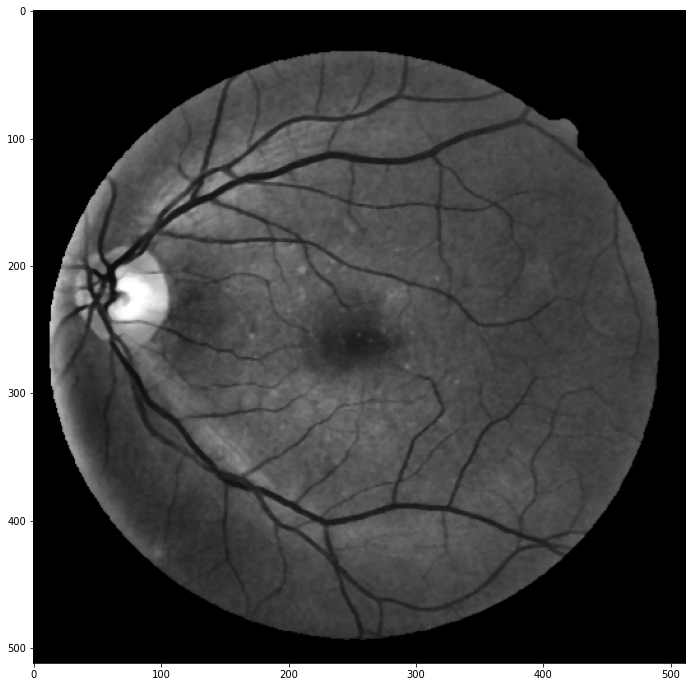

In [37]:
for data in data_loader:
    img = data['image'][0, 0].data.cpu().numpy()
plt.figure(figsize=(12, 12))
# plt.plot(auc_list)
plt.imshow(img, 'gray')

# Compare with Frangi vesselness



In [ ]:
from skimage.filters import frangi
for data in data_loader:
    img = data['image'][0, 0].data.cpu().numpy()
    break
    
frangives = frangi(img, np.linspace(1, 5, 10), black_ridges=True).astype(np.float32)*mask
thres_frangi = 1.841671457394114e-07

In [ ]:
mask = data['mask'][0, 0].data.cpu().numpy()
plt.figure(figsize=(18, 28))
plt.subplot(121)
plt.imshow(img, 'gray')
plt.axis('off')
plt.subplot(122)
plt.imshow((frangives) > thres_frangi, 'gray')
plt.axis('off')

# RetinaNet

Here, we load the retinanet predictions.

In [ ]:
with open('retinanet_drive_prediction.pkl', 'rb') as fi:
    retinanet_pred = pkl.load(fi)

In [ ]:
plt.figure(figsize=(14, 20))
plt.imshow(retinanet_pred[IDX, 0], 'gray')

# Comparison of methods




We compare the 3 methods (ours, frangi, retinaunet).

In [ ]:
plt.figure(figsize=(18, 18))
plt.subplot(221)
plt.imshow(g, 'gray'); plt.axis('off')
plt.title('Ground truth', fontsize=20)

plt.subplot(222)
plt.imshow(retinanet_pred[IDX, 0] > 0.5, 'gray'); plt.axis('off')
plt.title('Retina UNet', fontsize=20)

plt.subplot(223)
plt.imshow((frangives*mask) > thres_frangi, 'gray'); plt.axis('off')
plt.title('Frangi vesselness', fontsize=20)

plt.subplot(224)
plt.imshow((V) > thres_ours, 'gray'); plt.axis('off')
plt.title('Ours', fontsize=20)

plt.tight_layout()

In [ ]:
## Show the actual image too
plt.figure(figsize=(14, 14))
plt.imshow(img, 'gray'); plt.axis('off')
plt.title('Image', fontsize=25)
# plt.tight_layout()